# Learning tutorial 

A full example of predicting traffic demand.

In [13]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
sns.set()
from sklearn.linear_model import LinearRegression

import athena

First, we clear out the results.

In [14]:
if os.path.exists("results"):
    shutil.rmtree("results")

First, prepare the dataset.

In [15]:
dataset = athena.Dataset("../test/data/dfw_demand.csv.gz", 
                    index="timestamp", 
                    freq="30min",
                    max_days=500,
                    max_training_days=200,
                    predition_length=1,
                    test_start_values=["2019-07-27 00:00:00"],
                    test_sequence_length=96
                    )

This will produce two days (`test_sequence_length=96`) of back to back single step predictions (`predition_length=1`).

In [16]:
len(dataset.cv)

96

As mentioned earlier, the dataset is the standard form used by all algorithms included, but they need a transform function to put them in a standard input form.  For the Scikit Learn algorithms, we use the following transform and we define the target as `vehicles` and provide three dynamic real variables.

In [17]:
transform = athena.utils.sklearn.DataTransformSKLearn(target=['vehicles'], 
                                     dynamic_real=['vehicles_1', 'vehicles_2', 'vehicles_3'], 
                                     dynamic_cat=[])

For this example, we will use linear regression.

In [18]:
model = LinearRegression()

In our config, we can define a directory where we want the output to be written.  Normally the data will use a UUID for the output filenames, but this can be provided for testing if needed.

In [19]:
config = {'directory': 'results/linear',
          'uuid': 'test'}

Finally, we call the `evaluate_sklearn` function.

In [20]:
athena.utils.sklearn.evaluate_sklearn(dataset, transform, model, config)

This will create a CSV file and a JSON file with the results that is defined by the `config['directory]` and the `config['uuid']` value.  If you are using the generated UUID, you will need to `glob` the directory for filenames.

Here we read and plot the values in the JSON file.

In [21]:
original_config = json.loads(open('results/linear/results_test.json').read())
df = pd.read_csv("results/linear/results_test.csv")
df.columns = ['timestamp', 'predicted', 'actual', 'kind']

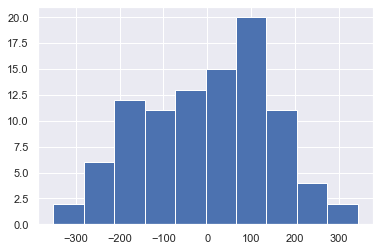

In [22]:
_ = plt.hist(df['actual']-df['predicted'], bins=10)

We can also look at the timeseries values in the CSV for one-step forecasting over the two day period.

In [23]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

<AxesSubplot:xlabel='timestamp'>

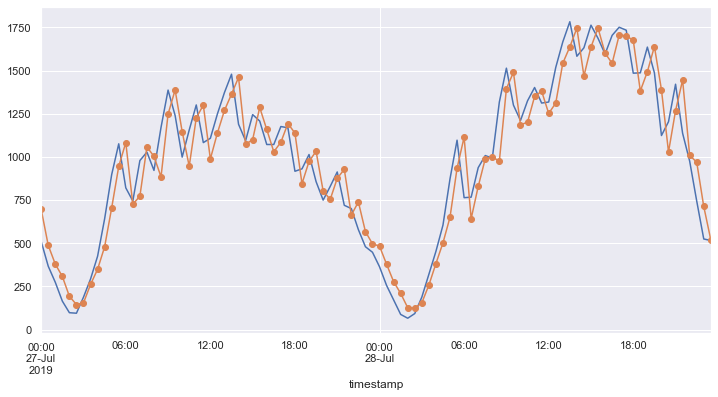

In [24]:
df['actual'].plot()
df['predicted'].plot(marker='o', figsize=(12,6))

## The config interface 

It is much easier to define and execute thousands using a config file.  This is the interface we encourage.

The above example could be defined using the following JSON configuration.

In [ ]:
config = {
    "filename": "../test/data/dfw_demand.csv.gz",
    "index": "timestamp",
    "freq": "30min",
    "max_days": 500,
    "max_training_days": 200,
    "prediction_length": 1,
    "test_start_values": ["2019-07-27 00:00:00"],
    "test_sequence_length": 96,
    "target": ["vehicles"],
    "dynamic_real": ["vehicles_1", "vehicles_2", "vehicles_3"],
    "dynamic_cat": [],
    "algorithm": "linear",
    "params": {},
    "directory": "results/linear",
    "uuid": "test"
}

To execute this configuration, we simple call:

In [26]:
import athena

athena.evaluate(config)

Here is a more complicated example, where we evaluate three different SKLearn algorithms.  We remove the `uuid` in this example.

In [27]:
configs = [ config.copy(), config.copy(), config.copy()]
configs[0]['algorithm'] = "linear"
configs[0]['directory'] = "results/linear"

configs[1]['algorithm'] = "svr"
configs[1]['directory'] = "results/svr"

configs[2]['algorithm'] = "xgboost"
configs[2]['directory'] = "results/xgboost"

for tmp in configs:
    del tmp['uuid']

Now we evaluate them

In [28]:
for test in configs:
    athena.evaluate(test)

And we can glob a list of file for lookinig at the results.

In [29]:
import glob

In [31]:
glob.glob("results/*/*.json")

['results/svr/results_trial-88e72304-f1fd-11ea-b427-acde48001122.json',
 'results/xgboost/results_trial-a7b130c2-f1fd-11ea-b427-acde48001122.json',
 'results/linear/results_trial-873d6e78-f1fd-11ea-b427-acde48001122.json',
 'results/linear/results_test.json']

Let's read the `json`files into a pandas dataframe.

In [36]:
res = pd.DataFrame([ json.loads(open(x).read()) for x in glob.glob("results/*/results_trial*.json") ])
res.shape

(3, 16)

In [38]:
res[['algorithm', 'uuid', 'params']]

,algorithm,uuid,params
0,svr,trial-88e72304-f1fd-11ea-b427-acde48001122,{}
1,xgboost,trial-a7b130c2-f1fd-11ea-b427-acde48001122,{}
2,linear,trial-873d6e78-f1fd-11ea-b427-acde48001122,{}
